## Поиск проблемы

In [179]:
import pandas as pd

In [180]:
orders = pd.read_csv("orders.csv")
device = pd.read_csv("device.csv")
display(orders)
display(device)

,order_id,order,order_price,user_id
0,999,"Мясной микс, 3 пиццы",1878,102475
1,680,Мясной микс,579,218841
2,687,Мясной микс,579,521065
3,685,Дьябло,560,106146
4,683,Сицилийская,545,854950
...,...,...,...,...
995,917,Четыре сыра,499,957570
996,919,Четыре сыра,499,957570
997,918,NaN,1080,957570
998,948,NaN,560,976203


,ip,device,operator_ip,user_id
0,192.168.66.187,unknown,192.168.215.115,102475
1,192.168.100.221,mobile,192.168.203.103,218841
2,192.168.100.221,mobile,192.168.202.102,521065
3,192.168.100.221,web,192.168.212.112,106146
4,192.168.100.221,mobile,192.168.217.117,854950
...,...,...,...,...
995,192.168.42.163,mobile,192.168.216.116,957570
996,192.168.42.163,mobile,192.168.205.105,957570
997,192.168.42.163,unknown,192.168.205.105,957570
998,192.168.79.200,unknown,192.168.213.113,976203


In [181]:
(orders["user_id"] == device["user_id"]).sum()

np.int64(1000)

Колонки user_id в наших датафреймах не просто выступают уникальными идентификаторами, но ещё и записаны с идеальной очерёдностью - поэтому наши датафреймы можно просто "склеить" друг с другом по горизонтали:

In [182]:
df = pd.concat([orders, device], axis=1)
df = df.loc[:,~df.columns.duplicated()].copy() # удаляем лишний столбец user_id за ненадобностью - после объединения он оказался продублирован
df

,order_id,order,order_price,user_id,ip,device,operator_ip
0,999,"Мясной микс, 3 пиццы",1878,102475,192.168.66.187,unknown,192.168.215.115
1,680,Мясной микс,579,218841,192.168.100.221,mobile,192.168.203.103
2,687,Мясной микс,579,521065,192.168.100.221,mobile,192.168.202.102
3,685,Дьябло,560,106146,192.168.100.221,web,192.168.212.112
4,683,Сицилийская,545,854950,192.168.100.221,mobile,192.168.217.117
...,...,...,...,...,...,...,...
995,917,Четыре сыра,499,957570,192.168.42.163,mobile,192.168.216.116
996,919,Четыре сыра,499,957570,192.168.42.163,mobile,192.168.205.105
997,918,NaN,1080,957570,192.168.42.163,unknown,192.168.205.105
998,948,NaN,560,976203,192.168.79.200,unknown,192.168.213.113


Первым делом создадим признак `order_missing` - своего рода таргет, который показывает, пропущено ли значение в колонке `order`:

In [183]:
df["order_missing"] = df["order"].isna()
df["order_missing"]

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997     True
998     True
999    False
Name: order_missing, Length: 1000, dtype: bool

Каков масштаб трагедии - сколько значений в колонке `order` пропущено?

In [184]:
print(f"Количество пропусков в колонке orders: {df["order"].isna().sum()}")
print(f"Доля пропусков в колонке orders: {df["order"].isna().sum() / df.shape[0]}")

Количество пропусков в колонке orders: 269
Доля пропусков в колонке orders: 0.269


Итак, имеем дело с примерно 27% пропусков - довольно много.

Посмотрим на колонку `operator_ip` поподробнее - а именно на её уникальные значения и их количество:

In [185]:
print(f"IP-адреса операторов: {df["operator_ip"].unique()}")
print(f"Количество операторов в выборке: {len(df["operator_ip"].unique())}")

IP-адреса операторов: ['192.168.215.115' '192.168.203.103' '192.168.202.102' '192.168.212.112'
 '192.168.217.117' '192.168.209.109' '192.168.213.113' '192.168.208.108'
 '192.168.216.116' '192.168.204.104' '192.168.211.111' '192.168.206.106'
 '192.168.85.206' '192.168.205.105' '192.168.214.114' '192.168.207.107'
 '192.168.210.110' '192.168.91.212' '192.168.218.118' '192.168.46.167']
Количество операторов в выборке: 20


С помощью сводной таблицы проверим, что проблема не в операторах:

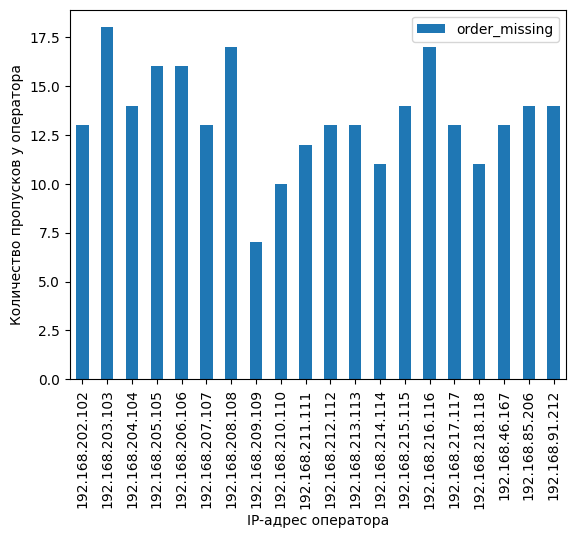

In [186]:
df.pivot_table(index="operator_ip", values="order_missing", aggfunc="sum").plot(kind="bar", xlabel="IP-адрес оператора", ylabel="Количество пропусков у оператора");

Как видим, особых аномалий у операторов не наблюдается - значит, никто из них, скорее всего, не "виноват" в потере данных.

Переходим к `order_id`: насколько я понял, id каждому заказу выдаётся по порядку - сначала 001, потом 002, и так далее до 999, а затем снова 001. Таким образом, можно использовать эту колонку как своего рода временной ряд и, если проблема возникла в какое-то определённое время, отследить её:

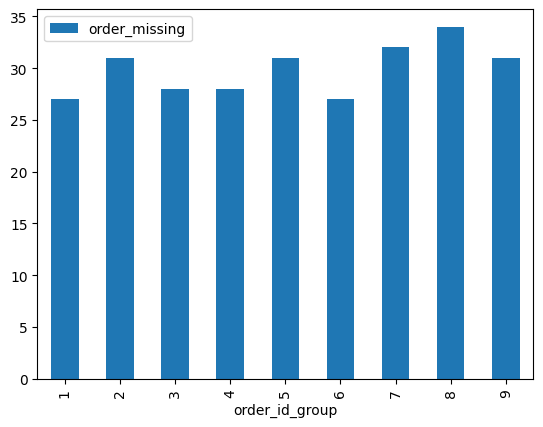

In [187]:
df["order_id_group"] = df["order_id"].apply(lambda x: str(x)[0])
df.pivot_table(index="order_id_group", values="order_missing", aggfunc="sum").plot(kind="bar");

Как видим, проблема произошла не в какое-то определённое время, поскольку распределение пропусков по заказам довольно равномерное.



Возможно, проблема с IP-адресами клиентов? Посмотрим на распределение 

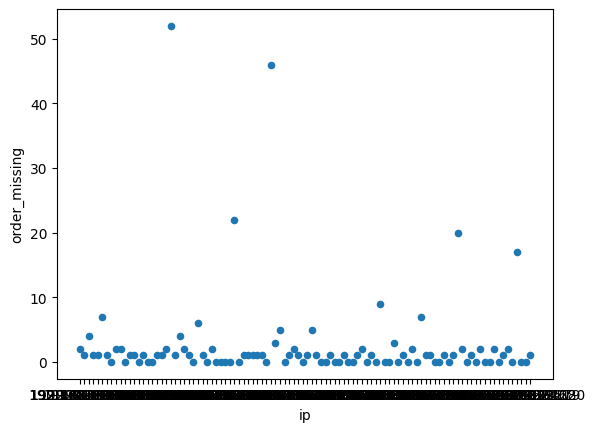

In [188]:
df_pivot_ip = df.pivot_table(index="ip", values="order_missing", aggfunc="sum")
df_pivot_ip["ip"] = df_pivot_ip.index
df_pivot_ip.plot(kind="scatter", x="ip", y="order_missing");

## Заполнение пропусков

Создадим таблицу с "меню" ресторана:

In [189]:
menu = df.pivot_table(index="order", values="order_price", aggfunc=lambda x: x.mode()[0])
menu

,order_price
order,
3 пиццы,1299
"3 пиццы, Вегетарианская",1809
"3 пиццы, Гавайская",1819
"3 пиццы, Гавайская, Сицилийская",2364
"3 пиццы, Дьябло",1859
...,...
"Четыре сыра, Маргарита",978
"Четыре сыра, Маргарита, Пеперони",1508
"Четыре сыра, Мясной микс",1078


In [190]:
menu_one_item = menu[~menu.index.str.contains(',')]
menu_one_item

,order_price
order,
3 пиццы,1299
Вегетарианская,510
Гавайская,520
Дьябло,560
Маргарита,479
Мясной микс,579
Неаполитанская,530
Пеперони,530
Сицилийская,545


Как видим, цены всех пицц, кроме Неаполитанской и Пеперони, уникальны - это даёт нам возможность однозначно заполнить все пропуски, где по цене видно, что в заказе только одна пицца (кроме случаев, когда цена равна 530 - это разберём далее).

Реализуем это:

In [191]:
df_one_pizza = df[df["order_price"].isin(menu_one_item["order_price"])]
df_one_pizza_no_530 = df_one_pizza[df_one_pizza["order_price"] != 530]
df_one_pizza_no_530.isna().sum()

order_id            0
order             146
order_price         0
user_id             0
ip                  0
device              0
operator_ip         0
order_missing       0
order_id_group      0
dtype: int64

In [192]:
price_to_pizza = dict(zip(menu_one_item['order_price'], menu_one_item.index))
price_to_pizza

{1299: '3 пиццы',
 510: 'Вегетарианская',
 520: 'Гавайская',
 560: 'Дьябло',
 479: 'Маргарита',
 579: 'Мясной микс',
 530: 'Пеперони',
 545: 'Сицилийская',
 499: 'Четыре сыра'}

In [193]:
for index, row in df_one_pizza_no_530.iterrows():
    if pd.isnull(row['order']):
        order_price = row['order_price']
        df_one_pizza_no_530.at[index, 'order'] = price_to_pizza[order_price]
df_one_pizza_no_530

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
1,680,Мясной микс,579,218841,192.168.100.221,mobile,192.168.203.103,False,6
2,687,Мясной микс,579,521065,192.168.100.221,mobile,192.168.202.102,False,6
3,685,Дьябло,560,106146,192.168.100.221,web,192.168.212.112,False,6
4,683,Сицилийская,545,854950,192.168.100.221,mobile,192.168.217.117,False,6
9,688,Вегетарианская,510,896258,192.168.100.221,unknown,192.168.216.116,False,6
...,...,...,...,...,...,...,...,...,...
990,804,Гавайская,520,249932,192.168.30.151,mobile,192.168.85.206,False,8
991,802,Вегетарианская,510,796033,192.168.30.151,web,192.168.206.106,False,8
995,917,Четыре сыра,499,957570,192.168.42.163,mobile,192.168.216.116,False,9
996,919,Четыре сыра,499,957570,192.168.42.163,mobile,192.168.205.105,False,9


Успешно заполнили все пропуски, в которых присутствует только одна пицца, и цена не равна 530. Теперь разберёмся со строками, где цена равна 530:

In [194]:
df_one_pizza_530 = df[df["order_price"] == 530]
df_one_pizza_530.isna().sum()

order_id           0
order             39
order_price        0
user_id            0
ip                 0
device             0
operator_ip        0
order_missing      0
order_id_group     0
dtype: int64

Здесь заполним пропуски следующим образом: для каждого `ip` найдём моду по непропущенным значениям `order` (тем самым выясним, какую из двух возможных пицц человек с данным ip-адресом чаще всего заказывает) - и именно этим значением заполним пропуски:

In [195]:
df_one_pizza_530["ip"].nunique()

32

In [196]:
df_pivot_id_modes = df_one_pizza_530[df_one_pizza_530["order"].notna()].groupby("ip").agg(func=lambda x:x.mode()[0])["order"]
for ip in df_pivot_id_modes.index:
    df_one_pizza_530.loc[df_one_pizza_530["ip"] == ip, "order"] = df_one_pizza_530.loc[df_one_pizza_530["ip"] == ip, "order"].fillna(df_pivot_id_modes[ip])
df_one_pizza_530

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
5,678,Пеперони,530,263835,192.168.100.221,web,192.168.209.109,True,6
6,681,Пеперони,530,948406,192.168.100.221,mobile,192.168.213.113,True,6
7,696,Пеперони,530,106146,192.168.100.221,unknown,192.168.208.108,False,6
8,692,Пеперони,530,657404,192.168.100.221,mobile,192.168.213.113,False,6
20,969,NaN,530,603670,192.168.61.182,web,192.168.209.109,True,9
...,...,...,...,...,...,...,...,...,...
937,428,Пеперони,530,928693,192.168.84.205,unknown,192.168.85.206,False,4
938,442,Пеперони,530,739072,192.168.84.205,unknown,192.168.210.110,False,4
939,462,Пеперони,530,927623,192.168.84.205,mobile,192.168.210.110,False,4
988,801,Неаполитанская,530,682484,192.168.30.151,web,192.168.208.108,False,8


In [197]:
df_one_pizza_530["order"].isna().sum()

np.int64(7)

Практически все пропуски заполнены - осталось 7 штук. Их заполним простой модой:

In [198]:
df_one_pizza_530["order"] = df_one_pizza_530["order"].fillna(df_one_pizza_530["order"].mode()[0])
df_one_pizza_530["order"]

C:\Users\mtkar\AppData\Local\Temp\ipykernel_4308\1686159459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_one_pizza_530["order"] = df_one_pizza_530["order"].fillna(df_one_pizza_530["order"].mode()[0])


5            Пеперони
6            Пеперони
7            Пеперони
8            Пеперони
20     Неаполитанская
            ...      
937          Пеперони
938          Пеперони
939          Пеперони
988    Неаполитанская
989          Пеперони
Name: order, Length: 141, dtype: object

Теперь заменим строки в датафрейме df_one_pizzа на строки с соответствующими `order_id` из датафреймов df_one_pizza_no_530 и df_one_pizza_530 - по сути дела, "сохраним наши наработки в исходный датафрейм:

In [199]:
for order_id in df_one_pizza_530["order_id"]:
    df_one_pizza.loc[df_one_pizza["order_id"] == order_id] = df_one_pizza_530
for order_id in df_one_pizza_no_530["order_id"]:
    df_one_pizza.loc[df_one_pizza["order_id"] == order_id] = df_one_pizza_no_530

df_one_pizza

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
1,680,Мясной микс,579,218841,192.168.100.221,mobile,192.168.203.103,False,6
2,687,Мясной микс,579,521065,192.168.100.221,mobile,192.168.202.102,False,6
3,685,Дьябло,560,106146,192.168.100.221,web,192.168.212.112,False,6
4,683,Сицилийская,545,854950,192.168.100.221,mobile,192.168.217.117,False,6
5,678,Пеперони,530,263835,192.168.100.221,web,192.168.209.109,True,6
...,...,...,...,...,...,...,...,...,...
990,804,Гавайская,520,249932,192.168.30.151,mobile,192.168.85.206,False,8
991,802,Вегетарианская,510,796033,192.168.30.151,web,192.168.206.106,False,8
995,917,Четыре сыра,499,957570,192.168.42.163,mobile,192.168.216.116,False,9
996,919,Четыре сыра,499,957570,192.168.42.163,mobile,192.168.205.105,False,9


In [200]:
df_one_pizza["order"].isna().sum()

np.int64(0)

In [201]:
del(df_one_pizza_530, df_one_pizza_no_530)

Пропуски в заказах с одной пиццей заполнили. Переходим к заказам с двумя пиццами:

In [202]:
menu["order"] = menu.index
menu["order"] = menu["order"].apply(lambda order:', '.join(sorted(order.split(', '))))
menu.index=menu["order"]
menu.drop("order", axis=1, inplace=True)
menu_two_items = menu[menu.index.str.count(',') == 1]
menu_two_items

,order_price
order,
"3 пиццы, Вегетарианская",1809
"3 пиццы, Гавайская",1819
"3 пиццы, Дьябло",1859
"3 пиццы, Маргарита",1778
"3 пиццы, Мясной микс",1878
...,...
"Дьябло, Четыре сыра",1059
"Маргарита, Четыре сыра",978
"Мясной микс, Четыре сыра",1078


При работе со строками, где присутствует лишь одна пицца, мы столкнулись с двумя пиццами, стоящими одинаково - Неаполитанская и Пеперони. Посмотрим, сколько таких значений в заказах с двумя пиццами:

In [203]:
(menu_two_items.value_counts() > 1).sum()

np.int64(31)

Здесь таких значений уже 31 - почти половина. К их заполнению вернёмся позже, а сейчас заполним однозначные пропуски:

In [204]:
df_two_pizzas = df[df["order_price"].isin(menu_two_items["order_price"])]
df_two_pizzas

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
0,999,"Мясной микс, 3 пиццы",1878,102475,192.168.66.187,unknown,192.168.215.115,False,9
14,691,NaN,1778,176837,192.168.100.221,web,192.168.203.103,True,6
16,679,"Неаполитанская, Дьябло",1090,827595,192.168.100.221,mobile,192.168.216.116,False,6
17,695,"Вегетарианская, Дьябло",1070,106146,192.168.100.221,web,192.168.206.106,False,6
18,690,"Гавайская, Пеперони",1050,476835,192.168.100.221,mobile,192.168.85.206,False,6
...,...,...,...,...,...,...,...,...,...
981,456,"Сицилийская, Четыре сыра",1044,548845,192.168.84.205,mobile,192.168.205.105,False,4
982,468,"Маргарита, Дьябло",1039,823250,192.168.84.205,unknown,192.168.213.113,False,4
983,449,"Вегетарианская, Четыре сыра",1009,917417,192.168.84.205,web,192.168.204.104,False,4
992,799,"3 пиццы, Мясной микс",1878,681378,192.168.30.151,unknown,192.168.202.102,False,7


In [205]:
df_two_pizzas_no_dup = df_two_pizzas[~df_two_pizzas["order"].isin(menu_two_items.loc[menu_two_items.duplicated()].index)]
df_two_pizzas_no_dup.isna().sum()

order_id           0
order             58
order_price        0
user_id            0
ip                 0
device             0
operator_ip        0
order_missing      0
order_id_group     0
dtype: int64

In [206]:
price_to_pizza = dict(zip(menu_two_items['order_price'], menu_two_items.index))
price_to_pizza

{1809: '3 пиццы, Вегетарианская',
 1819: '3 пиццы, Гавайская',
 1859: '3 пиццы, Дьябло',
 1778: '3 пиццы, Маргарита',
 1878: '3 пиццы, Мясной микс',
 1829: '3 пиццы, Пеперони',
 1844: '3 пиццы, Сицилийская',
 1798: '3 пиццы, Четыре сыра',
 1070: 'Вегетарианская, Дьябло',
 1089: 'Вегетарианская, Мясной микс',
 1040: 'Вегетарианская, Пеперони',
 1055: 'Вегетарианская, Сицилийская',
 1009: 'Вегетарианская, Четыре сыра',
 1030: 'Вегетарианская, Гавайская',
 1080: 'Гавайская, Дьябло',
 999: 'Гавайская, Маргарита',
 1099: 'Гавайская, Мясной микс',
 1050: 'Гавайская, Пеперони',
 1065: 'Гавайская, Сицилийская',
 1019: 'Гавайская, Четыре сыра',
 1039: 'Дьябло, Маргарита',
 1139: 'Дьябло, Мясной микс',
 1090: 'Дьябло, Пеперони',
 1105: 'Дьябло, Сицилийская',
 989: 'Вегетарианская, Маргарита',
 1058: 'Маргарита, Мясной микс',
 1024: 'Маргарита, Сицилийская',
 978: 'Маргарита, Четыре сыра',
 1109: 'Мясной микс, Неаполитанская',
 1124: 'Мясной микс, Сицилийская',
 1060: 'Неаполитанская, Пеперони',


In [207]:
for index, row in df_two_pizzas_no_dup.iterrows():
    if pd.isnull(row['order']):
        order_price = row['order_price']
        df_two_pizzas_no_dup.at[index, 'order'] = price_to_pizza[order_price]
df_two_pizzas_no_dup

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
0,999,"Мясной микс, 3 пиццы",1878,102475,192.168.66.187,unknown,192.168.215.115,False,9
14,691,"3 пиццы, Маргарита",1778,176837,192.168.100.221,web,192.168.203.103,True,6
16,679,"Неаполитанская, Дьябло",1090,827595,192.168.100.221,mobile,192.168.216.116,False,6
19,694,"Вегетарианская, Неаполитанская",1040,502631,192.168.100.221,web,192.168.205.105,False,6
21,970,"Пеперони, Дьябло",1090,110406,192.168.61.182,web,192.168.209.109,False,9
...,...,...,...,...,...,...,...,...,...
974,416,"Мясной микс, Дьябло",1139,693543,192.168.84.205,unknown,192.168.46.167,False,4
975,425,"Неаполитанская, Мясной микс",1109,410829,192.168.84.205,web,192.168.207.107,False,4
976,422,"Дьябло, Пеперони",1090,724452,192.168.84.205,mobile,192.168.214.114,True,4
982,468,"Маргарита, Дьябло",1039,823250,192.168.84.205,unknown,192.168.213.113,False,4


In [208]:
df_two_pizzas_no_dup["order"].isna().sum()

np.int64(0)

Все строки с двумя пиццами, которые можно было заполнить однозначно, заполнили.

Перейдём к заполнению остальных пропусков:

In [209]:
df_two_pizzas_dup = df_two_pizzas[df_two_pizzas["order"].isin(menu_two_items.loc[menu_two_items.duplicated()].index)]
df_two_pizzas_dup

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
17,695,"Вегетарианская, Дьябло",1070,106146,192.168.100.221,web,192.168.206.106,False,6
18,690,"Гавайская, Пеперони",1050,476835,192.168.100.221,mobile,192.168.85.206,False,6
37,875,"Гавайская, Маргарита",999,907417,192.168.74.195,mobile,192.168.212.112,False,8
83,626,"3 пиццы, Дьябло",1859,833717,192.168.96.217,mobile,192.168.217.117,False,6
86,617,"3 пиццы, Неаполитанская",1829,830589,192.168.96.217,mobile,192.168.215.115,False,6
...,...,...,...,...,...,...,...,...,...
979,417,"Пеперони, Сицилийская",1075,706211,192.168.84.205,mobile,192.168.209.109,False,4
980,424,"Неаполитанская, Пеперони",1060,593492,192.168.84.205,unknown,192.168.215.115,False,4
981,456,"Сицилийская, Четыре сыра",1044,548845,192.168.84.205,mobile,192.168.205.105,False,4
983,449,"Вегетарианская, Четыре сыра",1009,917417,192.168.84.205,web,192.168.204.104,False,4


In [210]:
df_two_pizzas_dup["order"].isna().sum()

np.int64(0)

Отлично! В заказах с двумя пиццами, где мы не можем однозначно заполнить пропуски, их и не оказалось. Поэтому добавим результат нашей работы в исходную таблицу и перейдём к заказам с тремя пиццами: 

In [211]:
for order_id in df_two_pizzas_no_dup["order_id"]:
    df_two_pizzas.loc[df_two_pizzas["order_id"] == order_id] = df_two_pizzas_no_dup

df_two_pizzas["order"].isna().sum()

np.int64(0)

In [212]:
del(menu_two_items, df_two_pizzas_dup, df_two_pizzas_no_dup)

Успешно заполнили все пропуски в заказах с двумя пиццами. Переходим к трём:

In [213]:
menu_three_items = menu[menu.index.str.count(',') == 2]
menu_three_items

,order_price
order,
"3 пиццы, Гавайская, Сицилийская",2364
"3 пиццы, Дьябло, Мясной микс",2438
"3 пиццы, Мясной микс, Четыре сыра",2377
"3 пиццы, Вегетарианская, Пеперони",2339
"3 пиццы, Гавайская, Пеперони",2349
...,...
"Неаполитанская, Пеперони, Сицилийская",1605
"Дьябло, Пеперони, Сицилийская",1635
"Маргарита, Пеперони, Сицилийская",1554


Аналогичным образом выведем все заказы, которые имеют уникальную цену:

In [214]:
df_three_pizzas = df[df["order_price"].isin(menu_three_items["order_price"])]
df_three_pizzas["order"].isna().sum()

np.int64(16)

In [215]:
df_three_pizzas_no_dup = df_three_pizzas[~df_three_pizzas["order"].isin(menu_three_items.loc[menu_three_items.duplicated()].index)]
df_three_pizzas_no_dup["order"].isna().sum()

np.int64(16)

16 пропусков можем заполнить однозначно - сделаем это:

In [216]:
price_to_pizza = dict(zip(menu_three_items['order_price'], menu_three_items.index))
price_to_pizza

{2364: '3 пиццы, Гавайская, Сицилийская',
 2438: '3 пиццы, Дьябло, Мясной микс',
 2377: '3 пиццы, Мясной микс, Четыре сыра',
 2339: '3 пиццы, Вегетарианская, Пеперони',
 2349: '3 пиццы, Гавайская, Пеперони',
 1588: 'Вегетарианская, Мясной микс, Четыре сыра',
 1560: 'Вегетарианская, Гавайская, Пеперони',
 1600: 'Вегетарианская, Дьябло, Неаполитанская',
 1570: 'Вегетарианская, Неаполитанская, Пеперони',
 1554: 'Маргарита, Пеперони, Сицилийская',
 1559: 'Гавайская, Дьябло, Маргарита',
 1529: 'Гавайская, Маргарита, Пеперони',
 1629: 'Гавайская, Мясной микс, Пеперони',
 2318: '3 пиццы, Гавайская, Четыре сыра',
 1598: 'Гавайская, Мясной микс, Четыре сыра',
 2369: '3 пиццы, Вегетарианская, Дьябло',
 1584: 'Дьябло, Маргарита, Сицилийская',
 1618: 'Дьябло, Маргарита, Мясной микс',
 1569: 'Вегетарианская, Дьябло, Четыре сыра',
 1589: 'Дьябло, Неаполитанская, Четыре сыра',
 2404: '3 пиццы, Дьябло, Сицилийская',
 2298: '3 пиццы, Гавайская, Маргарита',
 1509: 'Вегетарианская, Гавайская, Маргарита',

In [217]:
for index, row in df_three_pizzas_no_dup.iterrows():
    if pd.isnull(row['order']):
        order_price = row['order_price']
        df_three_pizzas_no_dup.at[index, 'order'] = price_to_pizza[order_price]
df_three_pizzas_no_dup

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
23,973,"Вегетарианская, Пеперони, 3 пиццы",2339,520224,192.168.56.177,web,192.168.214.114,False,9
27,854,"Мясной микс, Пеперони, Сицилийская",1654,120373,192.168.65.186,web,192.168.216.116,False,8
31,971,"Четыре сыра, Дьябло, Вегетарианская",1569,126546,192.168.15.136,unknown,192.168.209.109,False,9
80,628,"Гавайская, 3 пиццы, Сицилийская",2364,175019,192.168.96.217,mobile,192.168.216.116,False,6
81,607,"3 пиццы, Гавайская, Четыре сыра",2318,666054,192.168.96.217,unknown,192.168.202.102,True,6
...,...,...,...,...,...,...,...,...,...
905,808,"Мясной микс, Неаполитанская, Сицилийская",1654,912391,192.168.32.153,unknown,192.168.205.105,True,8
965,432,"Вегетарианская, Дьябло, Неаполитанская",1600,459391,192.168.84.205,mobile,192.168.208.108,True,4
966,466,"Гавайская, Маргарита, Дьябло",1559,924197,192.168.84.205,mobile,192.168.215.115,False,4
994,996,"Мясной микс, Неаполитанская, Вегетарианская",1619,957297,192.168.22.143,unknown,192.168.213.113,False,9


Перейдём к пропускам, которые однозначно заполнить не получится:

In [218]:
df_three_pizzas_dup = df_three_pizzas[df_three_pizzas["order"].isin(menu_three_items.loc[menu_three_items.duplicated()].index)]
df_three_pizzas_dup["order"].isna().sum()

np.int64(0)

И снова нам повезло - таких пропусков нет! Вернём нашу работу в основной датафрейм:

In [219]:
for order_id in df_three_pizzas_no_dup["order_id"]:
    df_three_pizzas.loc[df_three_pizzas["order_id"] == order_id] = df_three_pizzas_no_dup

df_three_pizzas["order"].isna().sum()

np.int64(0)

In [220]:
del(menu_three_items, df_three_pizzas_dup, df_three_pizzas_no_dup)

Перейдём к заказам с четырьмя пиццами:

In [221]:
menu_four_items = menu[menu.index.str.count(',') == 3]
menu_four_items

,order_price
order,


Таких заказов нет - мы заполнили все пропуски!

Вернём все наши данные в изначальный датафрейм df, чтобы проверить, что все пропуски заполнены успешно:

In [222]:
for order_id in df_one_pizza["order_id"]:
    df.loc[df["order_id"] == order_id] = df_one_pizza
for order_id in df_two_pizzas["order_id"]:
    df.loc[df["order_id"] == order_id] = df_two_pizzas
for order_id in df_three_pizzas["order_id"]:
    df.loc[df["order_id"] == order_id] = df_three_pizzas

df["order"].isna().sum()

np.int64(10)

У нас остались ещё несколько незаполненных пропусков - выведем их на экран, чтобы посмотреть на них поподробнее:

In [223]:
df[df["order"].isna()]

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
35,815,NaN,1649,300703,192.168.44.165,web,192.168.85.206,True,8
92,605,NaN,1544,396296,192.168.96.217,unknown,192.168.214.114,True,6
135,832,NaN,1623,615583,192.168.3.124,unknown,192.168.91.212,True,8
233,505,NaN,1549,685060,192.168.4.125,web,192.168.204.104,True,5
351,870,NaN,1649,353141,192.168.67.188,web,192.168.212.112,True,8
616,189,NaN,1684,506493,192.168.47.168,mobile,192.168.207.107,True,1
838,402,NaN,1579,798388,192.168.27.148,mobile,192.168.205.105,True,4
884,967,NaN,1625,409195,192.168.93.214,web,192.168.91.212,True,9
896,748,NaN,1549,863893,192.168.48.169,mobile,192.168.203.103,True,7
993,800,NaN,1590,418265,192.168.30.151,web,192.168.214.114,True,8


Судя по цене, во всех этих заказах три пиццы - и причина, почему они не появились в `menu_three_items` в том, что эти цены не фигурируют ни в каких не-пропущеных значениях. Поэтому заполним их простой модой по заказам с тремя пиццами (да, возможно, мы ошибёмся, но это всего 1% значений):

In [224]:
df = df.fillna(df_three_pizzas["order"].mode()[0])
df["order"].isna().sum()

np.int64(0)

Тем самым мы заполнили все пропуски в заказах, и практически все из них - однозначно.

Поскольку ранее мы не смогли установить никаких взаимосвязей между пропусками и имеющимися данными, возможно, стоит посмотреть на распределение самих пропущеных значений - может быть, оно нам подскажет, в чём причина?

In [225]:
df_missing = pd.concat([orders, device], axis=1)
df_missing = df_missing.loc[:,~df_missing.columns.duplicated()].copy()
df_missing_filled = df.loc[df_missing["order"].isna()]
df_missing_filled

,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group
5,678,Пеперони,530,263835,192.168.100.221,web,192.168.209.109,True,6
6,681,Пеперони,530,948406,192.168.100.221,mobile,192.168.213.113,True,6
13,682,Маргарита,479,642356,192.168.100.221,unknown,192.168.206.106,True,6
14,691,"3 пиццы, Маргарита",1778,176837,192.168.100.221,web,192.168.203.103,True,6
20,969,Неаполитанская,530,603670,192.168.61.182,web,192.168.209.109,True,9
...,...,...,...,...,...,...,...,...,...
976,422,"Дьябло, Пеперони",1090,724452,192.168.84.205,mobile,192.168.214.114,True,4
985,978,Маргарита,479,938521,192.168.81.202,web,192.168.46.167,True,9
993,800,"3 пиццы, Дьябло, Мясной микс",1590,418265,192.168.30.151,web,192.168.214.114,True,8
997,918,"Гавайская, Дьябло",1080,957570,192.168.42.163,unknown,192.168.205.105,True,9


Изначально IP-адрес - серия из 32 двоичных бит. Единственная причина, по которой в таблице они представлены в виде десятичных чисел и разделены запятыми - удобочитаемость для человека. Поэтому попробуем перевести все наши IP-адреса в двоичный вид - возможно, это поможет нам найти проблему:

In [226]:
df_missing_filled["bin_ip"] = df["ip"].apply(lambda ip: ''.join(format(int(octet), '08b') for octet in ip.split('.')))
df_missing_filled["bin_operator_ip"] = df["operator_ip"].apply(lambda ip: ''.join(format(int(octet), '08b') for octet in ip.split('.')))
df_missing_filled

C:\Users\mtkar\AppData\Local\Temp\ipykernel_4308\3558190855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_filled["bin_ip"] = df["ip"].apply(lambda ip: ''.join(format(int(octet), '08b') for octet in ip.split('.')))
C:\Users\mtkar\AppData\Local\Temp\ipykernel_4308\3558190855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_filled["bin_operator_ip"] = df["operator_ip"].apply(lambda ip: ''.join(format(int(octet), '08b') for octet in ip.split('.')))


,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group,bin_ip,bin_operator_ip
5,678,Пеперони,530,263835,192.168.100.221,web,192.168.209.109,True,6,11000000101010000110010011011101,11000000101010001101000101101101
6,681,Пеперони,530,948406,192.168.100.221,mobile,192.168.213.113,True,6,11000000101010000110010011011101,11000000101010001101010101110001
13,682,Маргарита,479,642356,192.168.100.221,unknown,192.168.206.106,True,6,11000000101010000110010011011101,11000000101010001100111001101010
14,691,"3 пиццы, Маргарита",1778,176837,192.168.100.221,web,192.168.203.103,True,6,11000000101010000110010011011101,11000000101010001100101101100111
20,969,Неаполитанская,530,603670,192.168.61.182,web,192.168.209.109,True,9,11000000101010000011110110110110,11000000101010001101000101101101
...,...,...,...,...,...,...,...,...,...,...,...
976,422,"Дьябло, Пеперони",1090,724452,192.168.84.205,mobile,192.168.214.114,True,4,11000000101010000101010011001101,11000000101010001101011001110010
985,978,Маргарита,479,938521,192.168.81.202,web,192.168.46.167,True,9,11000000101010000101000111001010,11000000101010000010111010100111
993,800,"3 пиццы, Дьябло, Мясной микс",1590,418265,192.168.30.151,web,192.168.214.114,True,8,11000000101010000001111010010111,11000000101010001101011001110010
997,918,"Гавайская, Дьябло",1080,957570,192.168.42.163,unknown,192.168.205.105,True,9,11000000101010000010101010100011,11000000101010001100110101101001


Поскольку первые 6 цифр (в десятичном представлении - то есть первые 16 битов в двоичном) у всех значений одни и те же, отсечём их:

In [227]:
df_missing_filled["bin_ip"] = df_missing_filled["bin_ip"].apply(lambda ip: ip[16:])
df_missing_filled["bin_operator_ip"] = df_missing_filled["bin_operator_ip"].apply(lambda ip: ip[16:])
df_missing_filled

C:\Users\mtkar\AppData\Local\Temp\ipykernel_4308\2404389550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_filled["bin_ip"] = df_missing_filled["bin_ip"].apply(lambda ip: ip[16:])
C:\Users\mtkar\AppData\Local\Temp\ipykernel_4308\2404389550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_filled["bin_operator_ip"] = df_missing_filled["bin_operator_ip"].apply(lambda ip: ip[16:])


,order_id,order,order_price,user_id,ip,device,operator_ip,order_missing,order_id_group,bin_ip,bin_operator_ip
5,678,Пеперони,530,263835,192.168.100.221,web,192.168.209.109,True,6,0110010011011101,1101000101101101
6,681,Пеперони,530,948406,192.168.100.221,mobile,192.168.213.113,True,6,0110010011011101,1101010101110001
13,682,Маргарита,479,642356,192.168.100.221,unknown,192.168.206.106,True,6,0110010011011101,1100111001101010
14,691,"3 пиццы, Маргарита",1778,176837,192.168.100.221,web,192.168.203.103,True,6,0110010011011101,1100101101100111
20,969,Неаполитанская,530,603670,192.168.61.182,web,192.168.209.109,True,9,0011110110110110,1101000101101101
...,...,...,...,...,...,...,...,...,...,...,...
976,422,"Дьябло, Пеперони",1090,724452,192.168.84.205,mobile,192.168.214.114,True,4,0101010011001101,1101011001110010
985,978,Маргарита,479,938521,192.168.81.202,web,192.168.46.167,True,9,0101000111001010,0010111010100111
993,800,"3 пиццы, Дьябло, Мясной микс",1590,418265,192.168.30.151,web,192.168.214.114,True,8,0001111010010111,1101011001110010
997,918,"Гавайская, Дьябло",1080,957570,192.168.42.163,unknown,192.168.205.105,True,9,0010101010100011,1100110101101001
